In [2]:
import dalex as dx
import xgboost
import shap

import sklearn

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

/home/jacek/Desktop/XAI/xai_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os

if not os.path.exists("plots"):
    os.mkdir("plots")

In [4]:
brain_stroke = pd.read_csv('brain_stroke.csv')
def preprocess_dataset(old_dataset):
  dataset = old_dataset.copy()

  columns = dataset.columns[:-1]
  for col in columns:
    if not dataset[col].astype(str).str.isnumeric().all():
      values = dataset[col].unique()
      if len(values) <= 1:
        dataset.drop(col, axis=1, inplace=True)
      elif len(values) == 2:
        val1 = 'yes' if 'yes' in values else values[0]
        dataset[col] = np.where(dataset[col] == val1, 1, 0)
      else:
        dummies = pd.get_dummies(dataset[[col]], prefix=col)
        dataset.drop(col, axis=1, inplace=True)
        dataset = pd.concat([dataset, dummies], axis=1)
  return dataset.drop(columns=['stroke']), dataset['stroke'].astype(np.float64)


X, y = preprocess_dataset(brain_stroke)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

0. XGBoost traning

In [5]:
model = xgboost.XGBClassifier()

params = {
    "max_depth": 5,
    "objective": "binary:logistic",
    "eval_metric": "auc"
}

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [6]:
pred_test = model.predict(X_test)
[print(f'Ground truth is {y_test.iloc[i]}, prediction is {pred_test[i]}') for i in range(3)]

Ground truth is 0.0, prediction is 0
Ground truth is 0.0, prediction is 0
Ground truth is 0.0, prediction is 0


[None, None, None]

In [7]:
explainer = dx.Explainer(model, X_test, y_test)

Preparation of a new explainer is initiated

  -> data              : 1495 rows 16 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1495 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7feaa7f22b90> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 9.69e-06, mean = 0.0327, max = 0.967
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.967, mean = 0.0194, max = 1.0
  -> model_info        : package xgboost

A new explainer has been created!


In [8]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
XGBClassifier,0.025641,0.111111,0.041667,0.938462,0.796229


1. Permutation-based Variable Importance for XGBoost

In [9]:
pvi = explainer.model_parts(random_state=0)

In [10]:
pvi.result

,variable,dropout_loss,label
0,smoking_status_Unknown,0.193820,XGBClassifier
1,hypertension,0.197141,XGBClassifier
2,work_type_Govt_job,0.197261,XGBClassifier
3,work_type_Self-employed,0.199562,XGBClassifier
4,work_type_children,0.199639,XGBClassifier
5,_full_model_,0.199639,XGBClassifier
6,gender,0.199954,XGBClassifier
7,smoking_status_formerly smoked,0.199975,XGBClassifier
8,bmi,0.200441,XGBClassifier
9,smoking_status_smokes,0.200524,XGBClassifier


In [11]:
plot_1 = pvi.plot(show=False).update_layout(autosize=False, width=600, height=450)
plot_1.write_image("plots/p1.png")

In [12]:
plot_2 = pvi.plot(
    max_vars=3, 
    digits=4, 
    bar_width=40, 
    title="Permutation-based Variable Importance (Top 3)", 
    show=False
).update_layout(width=600)
plot_2.write_image("plots/p2.png")

2.1. Second model: Decision Tree Regressor

In [13]:
from sklearn.tree import DecisionTreeClassifier
tree_class_1 = DecisionTreeClassifier(random_state=0, max_depth=4, max_features=4)
tree_class_1.fit(X_train, y_train)
pred_test_tree_1 = tree_class_1.predict(X_test)

2.2. Third model: Decision Tree Regressor with other hyperparameters

In [14]:
tree_class_2 = DecisionTreeClassifier(random_state=0, max_depth=8, max_features=8)
tree_class_2.fit(X_train, y_train)
pred_test_tree_2 = tree_class_2.predict(X_test)

2.3. Fourth model: Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
pred_test_rand_tree = clf.predict(X_test)

In [16]:
models = [tree_class_1, tree_class_2, clf]
explainers = [dx.Explainer(model, X_test, y_test) for model in models]
pvis = [expl.model_parts(random_state=0) for expl in explainers]

Preparation of a new explainer is initiated

  -> data              : 1495 rows 16 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1495 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7feaa7f22b90> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.0453, max = 0.375
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.375, mean = 0.0069, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 1495 rows 16 cols
  -> target variable   : Paramet

2.4. PVI plots for new three models

In [17]:
for i in range(3):
    print(f'PVI for {models[i]}')
    plot = pvis[i].plot(show=False)
    plot.write_image(f"plots/p{i+3}.png")

PVI for DecisionTreeClassifier(max_depth=4, max_features=4, random_state=0)
PVI for DecisionTreeClassifier(max_depth=8, max_features=8, random_state=0)
PVI for RandomForestClassifier(max_depth=5, random_state=0)


3a) Gini-based Variable Importance for XGBoost Classifier

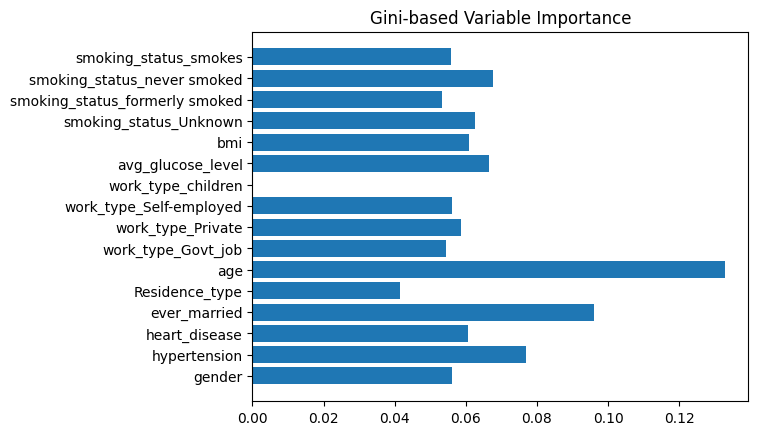

In [33]:
from matplotlib import pyplot as plt
plot_6 = plt.barh(X_test.columns, model.feature_importances_)
plt.title("Gini-based Variable Importance")
plt.savefig('plots/p6.png')

3b) SHAP variable importance based on the TreeSHAP algorithm available in the shap package.

In [31]:
shap_vi = explainer.model_parts(shap_explainer_type="TreeExplainer") #)#type="shap_wrapper", 
plot = shap_vi.plot(show=False)
plot.write_image("plots/p7.png")